1. Importing Libraries

In [48]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
import joblib

warnings.filterwarnings('ignore')

2. Dataset

In [49]:
la_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")


la_df.head()


,DATE OCC,TIME OCC,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,LAT,LON,Crm Cd Desc
0,05/10/2020 12:00:00 AM,2200,Central,30,F,W,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Arrest,700 N HILL PL,34.0618,-118.2424,INTIMATE PARTNER - SIMPLE ASSAULT
1,12/02/2020 12:00:00 AM,2245,77th Street,21,M,H,STREET,VERBAL THREAT,Invest Cont,SAN PEDRO,33.9610,-118.2695,ROBBERY
2,05/01/2020 12:00:00 AM,2330,77th Street,28,F,B,SINGLE FAMILY DWELLING,KNIFE WITH BLADE OVER 6 INCHES IN LENGTH,Invest Cont,100 E 82ND ST,33.9654,-118.2739,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT"
3,01/18/2020 12:00:00 AM,940,Central,42,M,A,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Arrest,200 E BLOOM ST,34.0639,-118.2295,BATTERY - SIMPLE ASSAULT
4,11/15/2020 12:00:00 AM,310,Rampart,36,M,W,RESTAURANT/FAST FOOD,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,1500 W SUNSET BL,34.0758,-118.2552,BURGLARY


2. Building Daily Summary

In [50]:
def build_daily_summary_rnn(df, top_k_values=5):
    

    df = df.copy()

    # Tarihi normalleştir
    df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
    df['day'] = df['DATE OCC'].dt.date
    df['hour'] = df['DATE OCC'].dt.hour

    # Eksik değerleri dolduralım (gerekirse daha ileri imputation yapılabilir)
    df['Vict Age'] = df['Vict Age'].fillna(df['Vict Age'].median())
    for col in ['Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc']:
        df[col] = df[col].fillna("UNKNOWN")

    grouped = df.groupby(['AREA NAME', 'day'])
    daily_features = []

    # Histogram kategorilerini kısıtlamak için en sık görülen kategoriler
    top_categories = {
        col: df[col].value_counts().nlargest(top_k_values).index.tolist()
        for col in ['Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc']
    }

    for (area, day), group in grouped:
        summary = {
            'AREA NAME': area,
            'DAY': day,
            'Vict_Age_Mean': group['Vict Age'].mean(),
            'Vict_Age_Max': group['Vict Age'].max(),
            'Crime_Count': len(group),
        }

        # Saat histogramı (0-23)
        hour_counts = group['hour'].value_counts(normalize=True)
        for h in range(24):
            summary[f'Hour_{h}'] = hour_counts.get(h, 0.0)

        # Kategorik histogramlar (ilk top_k değer için)
        for col in ['Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc']:
            counts = group[col].value_counts(normalize=True)
            for val in top_categories[col]:
                summary[f"{col}_{val}"] = counts.get(val, 0.0)

        # Etiket (o günün baskın suç türü)
        mode_crime = group['Crm Cd Desc'].mode()
        summary['Crime_Mode'] = mode_crime[0] if not mode_crime.empty else None

        daily_features.append(summary)

    return pd.DataFrame(daily_features)

In [51]:
daily_df = build_daily_summary_rnn(la_df)
daily_df.head()

,AREA NAME,DAY,Vict_Age_Mean,Vict_Age_Max,Crime_Count,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,...,Premis Desc_SINGLE FAMILY DWELLING,"Premis Desc_MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Premis Desc_SIDEWALK,Premis Desc_PARKING LOT,"Weapon Desc_STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Weapon Desc_UNKNOWN WEAPON/OTHER WEAPON,Weapon Desc_VERBAL THREAT,Weapon Desc_HAND GUN,Weapon Desc_SEMI-AUTOMATIC PISTOL,Crime_Mode
0,77th Street,2020-01-01,21.367347,53,49,1.0,0.0,0.0,0.0,0.0,...,0.367347,0.163265,0.081633,0.061224,0.775510,0.061224,0.020408,0.020408,0.000000,BATTERY - SIMPLE ASSAULT
1,77th Street,2020-01-02,31.176471,59,17,1.0,0.0,0.0,0.0,0.0,...,0.117647,0.058824,0.000000,0.000000,0.470588,0.000000,0.000000,0.235294,0.000000,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT"
2,77th Street,2020-01-03,34.208333,64,24,1.0,0.0,0.0,0.0,0.0,...,0.375000,0.041667,0.000000,0.125000,0.583333,0.000000,0.000000,0.041667,0.083333,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT"
3,77th Street,2020-01-04,29.166667,56,18,1.0,0.0,0.0,0.0,0.0,...,0.555556,0.000000,0.000000,0.111111,0.500000,0.055556,0.000000,0.166667,0.000000,BATTERY - SIMPLE ASSAULT
4,77th Street,2020-01-05,35.071429,68,28,1.0,0.0,0.0,0.0,0.0,...,0.250000,0.142857,0.178571,0.000000,0.428571,0.071429,0.035714,0.000000,0.285714,BATTERY - SIMPLE ASSAULT


Rare Filtering

In [52]:
value_counts = daily_df['Crime_Mode'].value_counts()
valid_classes = value_counts[value_counts >= 30].index
daily_df = daily_df[daily_df['Crime_Mode'].isin(valid_classes)]

Time Series Building

In [53]:
def create_sequences_rnn(daily_df, window_size=5, feature_cols=None):
    
    # Ihtiyac duyulabilir
    from collections import defaultdict
    

    data = []
    labels = []

    # Özellik sütunlarını belirle (DAY, AREA NAME ve Crime_Mode hariç)
    if feature_cols is None:
        exclude = ['AREA NAME', 'DAY', 'Crime_Mode']
        feature_cols = [col for col in daily_df.columns if col not in exclude]

    # Tüm konumlar için sırayla işle
    grouped = daily_df.groupby('AREA NAME')

    for area, group in grouped:
        group = group.sort_values(by='DAY').reset_index(drop=True)

        for i in range(len(group) - window_size):
            window = group.iloc[i:i+window_size]
            target_day = group.iloc[i+window_size]

            # Eksik etiket varsa atla
            if pd.isnull(target_day['Crime_Mode']):
                continue

            # X: (t, f) dizisi
            x_seq = window[feature_cols].values.astype(np.float32)
            y_label = target_day['Crime_Mode']

            data.append(x_seq)
            labels.append(y_label)

    return np.array(data), np.array(labels), feature_cols

In [54]:
X, y, feature_cols = create_sequences_rnn(daily_df, window_size=5)
print("X shape:", X.shape)  # (n, t, f)
print("y shape:", y.shape)

X shape: (34210, 5, 46)
y shape: (34210,)


Encoding and Normalization

In [55]:
def preprocess_sequences_rnn(X, y):
    
    n, t, f = X.shape
    X_reshaped = X.reshape(-1, f)  # (n*t, f)

    # Normalization
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(n, t, f)

    # Label encoding
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return X_scaled, y_encoded, scaler, le

In [56]:
X_scaled, y_encoded, scaler, label_encoder = preprocess_sequences_rnn(X, y)

print("X shape (scaled):", X_scaled.shape)
print("y shape (encoded):", y_encoded.shape)
print("Number of label classes:", len(label_encoder.classes_))

X shape (scaled): (34210, 5, 46)
y shape (encoded): (34210,)
Number of label classes: 26


Dataset and DataLoader

In [57]:
# Provides model to retrieve data by DataLoader
class CrimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (n, t, f)
        self.y = torch.tensor(y, dtype=torch.long)     # (n,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# y_encoded -> numpy array olduğu için Series'e dönüştür
y_series = pd.Series(y_encoded)

# Her sınıfın kaç tane örneği var?
value_counts = y_series.value_counts()

# En az 2 örneği olan sınıfları tut
valid_classes = value_counts[value_counts >= 30].index

# Bu sınıflarda kalan verileri filtrele
filtered_indices = y_series[y_series.isin(valid_classes)].index

# X ve y'yi filtrele
X_filtered = X_scaled[filtered_indices]
y_filtered = y_encoded[filtered_indices]    
    
# Eğitim ve test için ayır
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

# Dataset nesneleri
train_dataset = CrimeDataset(X_train, y_train)
test_dataset  = CrimeDataset(X_test, y_test)

# Dataloader’lar
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Model

In [58]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (B, T, F)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out: (B, T, H)
        out = out[:, -1, :]              # son zaman adımının çıktısı → (B, H)
        out = self.fc(out)              # (B, output_dim)
        return out

In [59]:
input_dim = X_train.shape[2]                 # f
output_dim = len(label_encoder.classes_)         # num of classes
hidden_dim = 128
num_layers = 1

model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers=num_layers, dropout=0.3)

Training

In [60]:
def train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for X_batch, y_batch in train_loader:
            # Reset
            optimizer.zero_grad()

            # Forward
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            total_correct += (outputs.argmax(1) == y_batch).sum().item()
            total_samples += y_batch.size(0)

        train_acc = total_correct / total_samples
        avg_loss = total_loss / total_samples

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {train_acc:.4f}")

    return model

In [61]:
# Usage
model = LSTMClassifier(input_dim, hidden_dim=128, output_dim=output_dim, num_layers=1, dropout=0.3)
model = train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.001)

Epoch 1/30 - Loss: 1.7619 - Accuracy: 0.4068
Epoch 2/30 - Loss: 1.6593 - Accuracy: 0.4231
Epoch 3/30 - Loss: 1.6459 - Accuracy: 0.4276
Epoch 4/30 - Loss: 1.6404 - Accuracy: 0.4273
Epoch 5/30 - Loss: 1.6353 - Accuracy: 0.4268
Epoch 6/30 - Loss: 1.6329 - Accuracy: 0.4281
Epoch 7/30 - Loss: 1.6296 - Accuracy: 0.4296
Epoch 8/30 - Loss: 1.6273 - Accuracy: 0.4312
Epoch 9/30 - Loss: 1.6256 - Accuracy: 0.4314
Epoch 10/30 - Loss: 1.6241 - Accuracy: 0.4318
Epoch 11/30 - Loss: 1.6225 - Accuracy: 0.4311
Epoch 12/30 - Loss: 1.6199 - Accuracy: 0.4331
Epoch 13/30 - Loss: 1.6183 - Accuracy: 0.4325
Epoch 14/30 - Loss: 1.6171 - Accuracy: 0.4334
Epoch 15/30 - Loss: 1.6137 - Accuracy: 0.4334
Epoch 16/30 - Loss: 1.6115 - Accuracy: 0.4354
Epoch 17/30 - Loss: 1.6105 - Accuracy: 0.4343
Epoch 18/30 - Loss: 1.6072 - Accuracy: 0.4364
Epoch 19/30 - Loss: 1.6053 - Accuracy: 0.4352
Epoch 20/30 - Loss: 1.6039 - Accuracy: 0.4357
Epoch 21/30 - Loss: 1.6012 - Accuracy: 0.4357
Epoch 22/30 - Loss: 1.5984 - Accuracy: 0.43

Evaluation


=== Evaluation Metrics ===
Accuracy : 0.429
F1 Score : 0.0674
Recall   : 0.0721
Precision: 0.1051

Classification Report:
                                                           precision    recall  f1-score   support

                                                   ARSON       0.00      0.00      0.00        14
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00        25
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.41      0.22      0.29      1961
                                       ATTEMPTED ROBBERY       0.00      0.00      0.00        48
                                BATTERY - SIMPLE ASSAULT       0.44      0.88      0.59      2804
                                 BATTERY POLICE (SIMPLE)       0.00      0.00      0.00        28
                             BATTERY WITH SEXUAL CONTACT       0.00      0.00      0.00        29
                                         BRANDISH WEAPON       0.00      0.00      0.00    

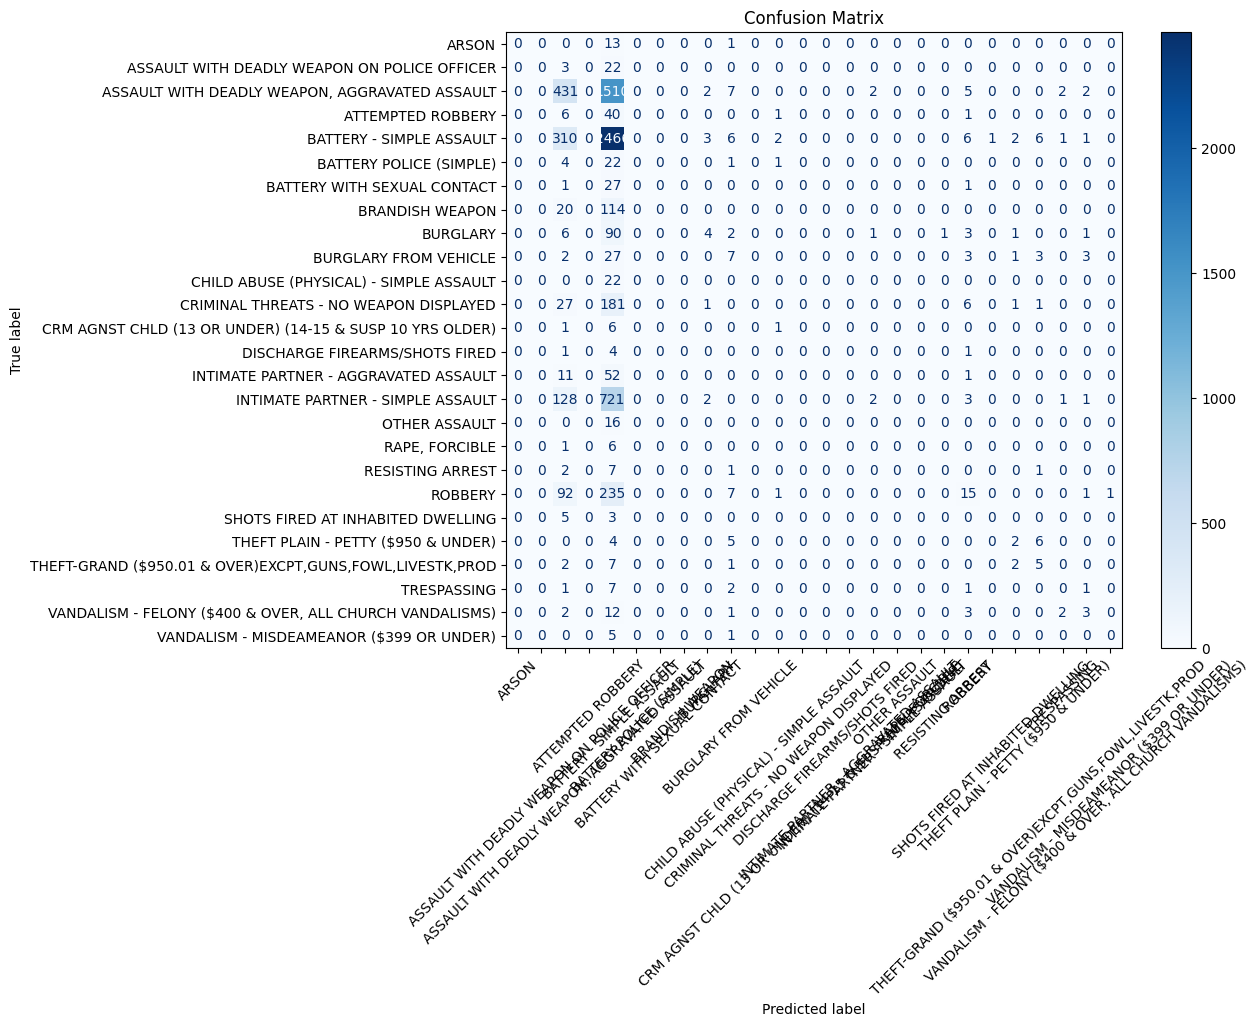

In [62]:
def evaluate_model(model, test_loader, label_encoder, show_cm=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")

    print("\n=== Evaluation Metrics ===")
    print("Accuracy :", round(acc, 4))
    print("F1 Score :", round(f1, 4))
    print("Recall   :", round(recall, 4))
    print("Precision:", round(precision, 4))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_true))))

    # Confusion Matrix (only for present labels)
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    display_labels = label_encoder.inverse_transform(unique_labels)
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return acc, f1, recall, precision

acc, f1, recall, precision = evaluate_model(model, test_loader, label_encoder)

Files which we use for the test.


=== Training for window size = 3 ===
Epoch 1/30 - Loss: 1.7366 - Accuracy: 0.4080
Epoch 2/30 - Loss: 1.6609 - Accuracy: 0.4226
Epoch 3/30 - Loss: 1.6508 - Accuracy: 0.4246
Epoch 4/30 - Loss: 1.6470 - Accuracy: 0.4287
Epoch 5/30 - Loss: 1.6411 - Accuracy: 0.4274
Epoch 6/30 - Loss: 1.6383 - Accuracy: 0.4260
Epoch 7/30 - Loss: 1.6366 - Accuracy: 0.4291
Epoch 8/30 - Loss: 1.6344 - Accuracy: 0.4299
Epoch 9/30 - Loss: 1.6315 - Accuracy: 0.4316
Epoch 10/30 - Loss: 1.6296 - Accuracy: 0.4297
Epoch 11/30 - Loss: 1.6263 - Accuracy: 0.4304
Epoch 12/30 - Loss: 1.6246 - Accuracy: 0.4317
Epoch 13/30 - Loss: 1.6212 - Accuracy: 0.4316
Epoch 14/30 - Loss: 1.6186 - Accuracy: 0.4323
Epoch 15/30 - Loss: 1.6152 - Accuracy: 0.4325
Epoch 16/30 - Loss: 1.6121 - Accuracy: 0.4338
Epoch 17/30 - Loss: 1.6085 - Accuracy: 0.4331
Epoch 18/30 - Loss: 1.6040 - Accuracy: 0.4350
Epoch 19/30 - Loss: 1.5993 - Accuracy: 0.4371
Epoch 20/30 - Loss: 1.5951 - Accuracy: 0.4382
Epoch 21/30 - Loss: 1.5892 - Accuracy: 0.4396
Epoch

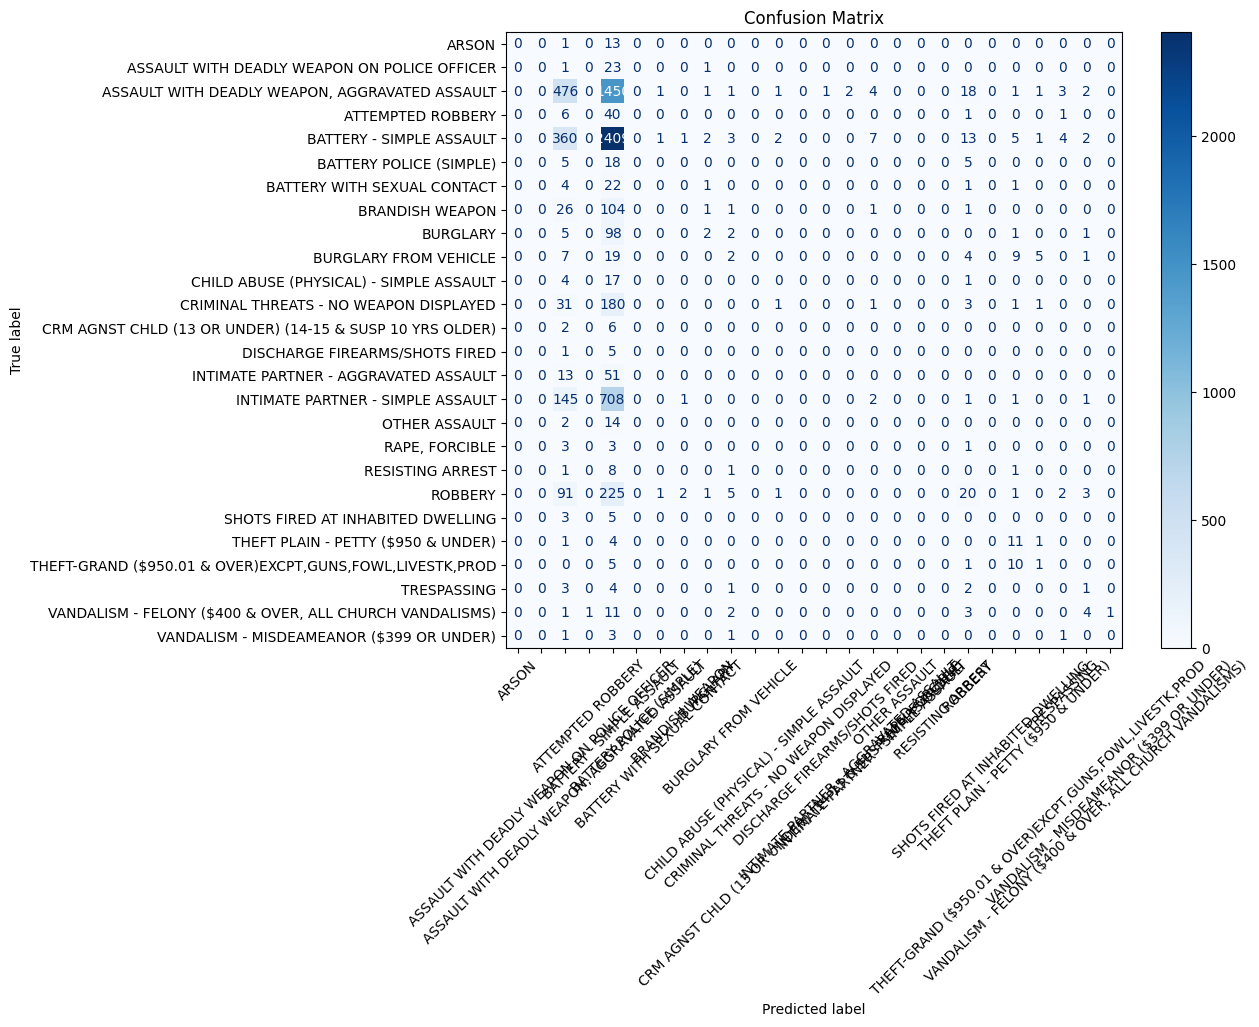

[Window=3] Accuracy: 0.4274, F1: 0.0671, Recall: 0.0809, Precision: 0.0922

=== Training for window size = 5 ===
Epoch 1/30 - Loss: 1.7165 - Accuracy: 0.4141
Epoch 2/30 - Loss: 1.6515 - Accuracy: 0.4244
Epoch 3/30 - Loss: 1.6417 - Accuracy: 0.4278
Epoch 4/30 - Loss: 1.6358 - Accuracy: 0.4291
Epoch 5/30 - Loss: 1.6317 - Accuracy: 0.4278
Epoch 6/30 - Loss: 1.6292 - Accuracy: 0.4308
Epoch 7/30 - Loss: 1.6263 - Accuracy: 0.4306
Epoch 8/30 - Loss: 1.6241 - Accuracy: 0.4308
Epoch 9/30 - Loss: 1.6228 - Accuracy: 0.4318
Epoch 10/30 - Loss: 1.6199 - Accuracy: 0.4318
Epoch 11/30 - Loss: 1.6176 - Accuracy: 0.4329
Epoch 12/30 - Loss: 1.6147 - Accuracy: 0.4348
Epoch 13/30 - Loss: 1.6114 - Accuracy: 0.4323
Epoch 14/30 - Loss: 1.6089 - Accuracy: 0.4325
Epoch 15/30 - Loss: 1.6051 - Accuracy: 0.4350
Epoch 16/30 - Loss: 1.6015 - Accuracy: 0.4352
Epoch 17/30 - Loss: 1.5966 - Accuracy: 0.4383
Epoch 18/30 - Loss: 1.5927 - Accuracy: 0.4378
Epoch 19/30 - Loss: 1.5874 - Accuracy: 0.4390
Epoch 20/30 - Loss: 1.

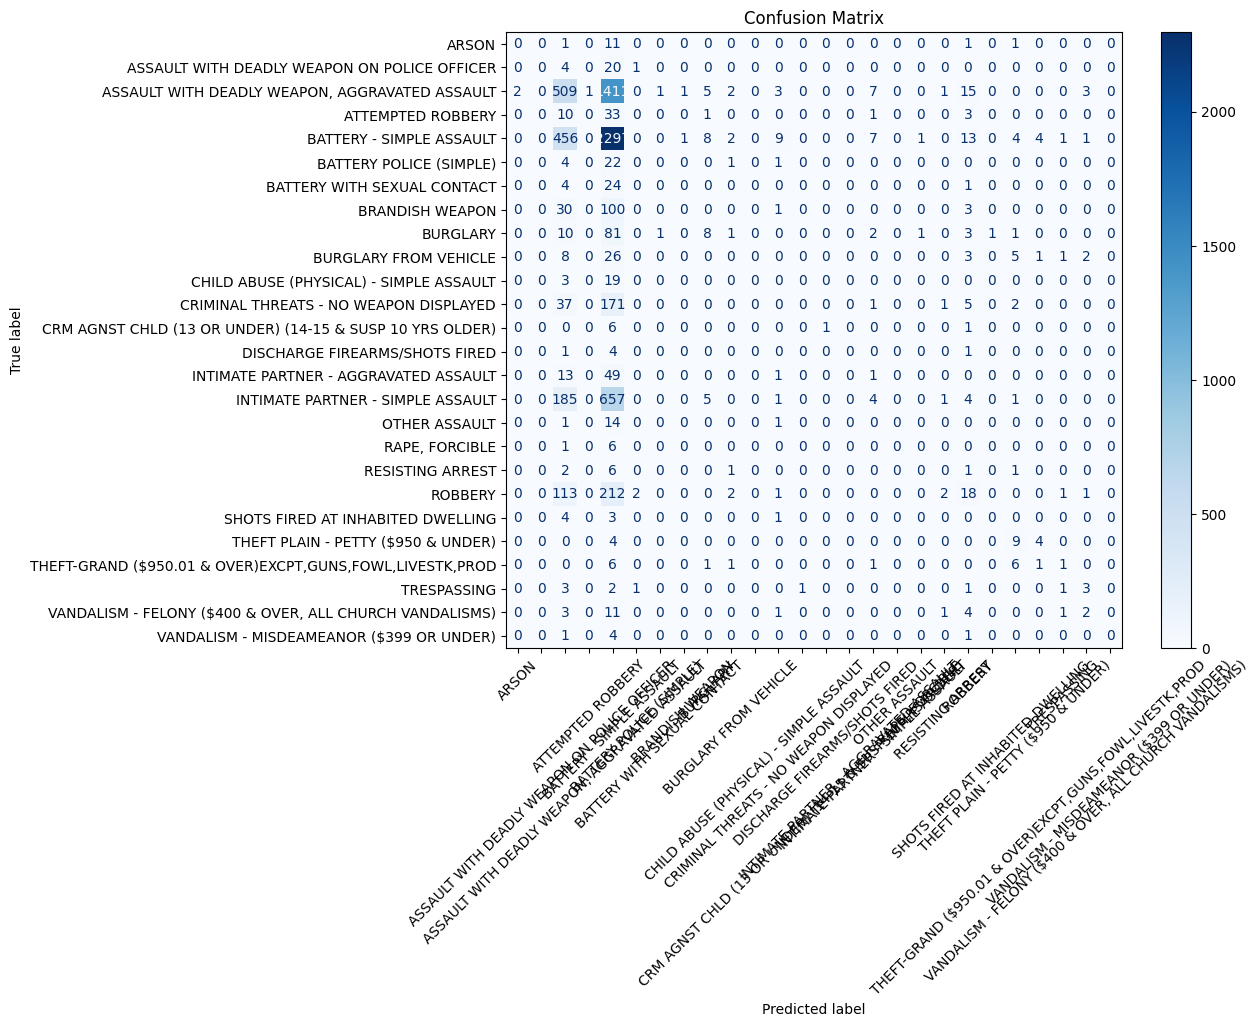

[Window=5] Accuracy: 0.4164, F1: 0.0680, Recall: 0.0756, Precision: 0.0854

=== Training for window size = 7 ===
Epoch 1/30 - Loss: 1.7176 - Accuracy: 0.4100
Epoch 2/30 - Loss: 1.6507 - Accuracy: 0.4212
Epoch 3/30 - Loss: 1.6405 - Accuracy: 0.4277
Epoch 4/30 - Loss: 1.6341 - Accuracy: 0.4296
Epoch 5/30 - Loss: 1.6299 - Accuracy: 0.4290
Epoch 6/30 - Loss: 1.6266 - Accuracy: 0.4297
Epoch 7/30 - Loss: 1.6234 - Accuracy: 0.4311
Epoch 8/30 - Loss: 1.6208 - Accuracy: 0.4303
Epoch 9/30 - Loss: 1.6180 - Accuracy: 0.4324
Epoch 10/30 - Loss: 1.6150 - Accuracy: 0.4327
Epoch 11/30 - Loss: 1.6133 - Accuracy: 0.4325
Epoch 12/30 - Loss: 1.6110 - Accuracy: 0.4339
Epoch 13/30 - Loss: 1.6076 - Accuracy: 0.4337
Epoch 14/30 - Loss: 1.6060 - Accuracy: 0.4334
Epoch 15/30 - Loss: 1.6025 - Accuracy: 0.4339
Epoch 16/30 - Loss: 1.5994 - Accuracy: 0.4335
Epoch 17/30 - Loss: 1.5957 - Accuracy: 0.4363
Epoch 18/30 - Loss: 1.5920 - Accuracy: 0.4372
Epoch 19/30 - Loss: 1.5882 - Accuracy: 0.4381
Epoch 20/30 - Loss: 1.

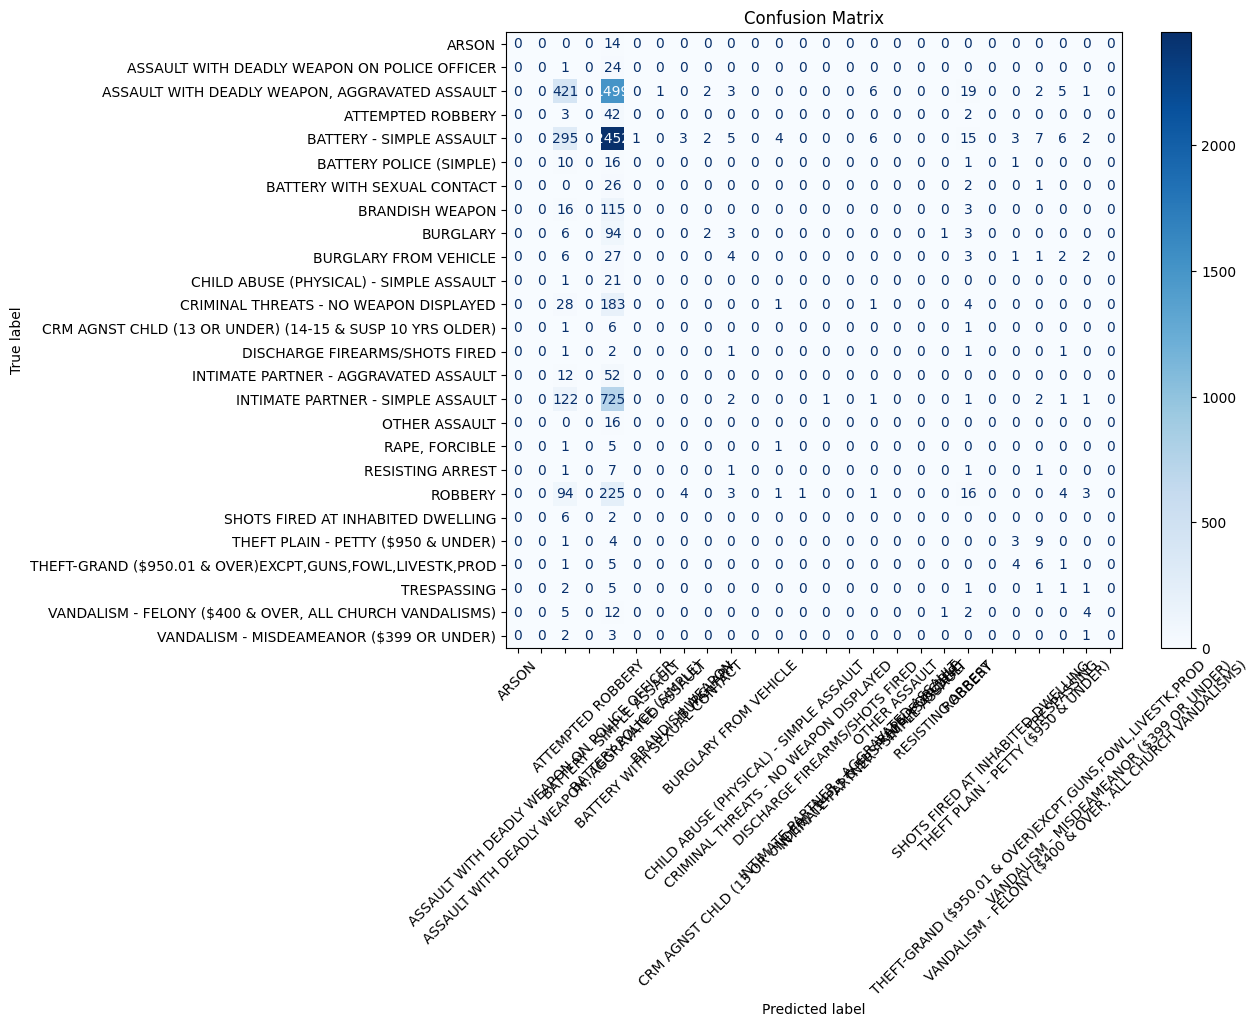

[Window=7] Accuracy: 0.4260, F1: 0.0706, Recall: 0.0782, Precision: 0.0980

=== Summary of Results ===
   window_size  accuracy  f1_score    recall  precision
0            3  0.427383  0.067100  0.080936   0.092211
1            5  0.416399  0.068026  0.075633   0.085427
2            7  0.425958  0.070560  0.078224   0.097997


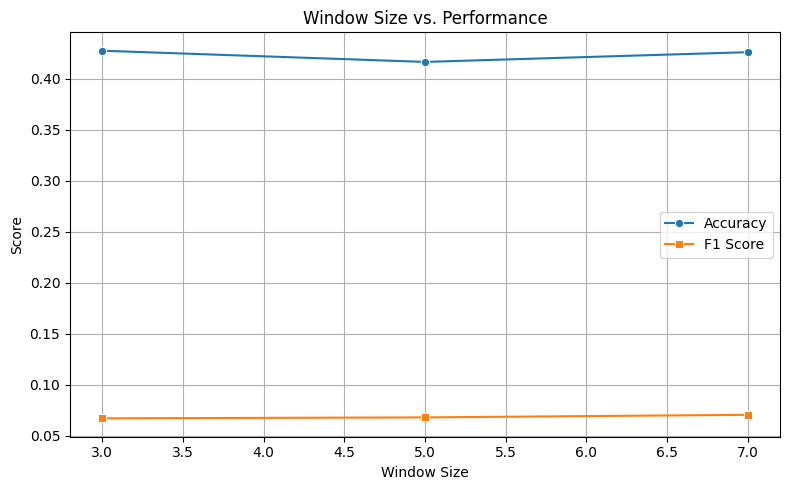

In [63]:
def run_experiment(daily_df, window_sizes, model_class, model_params,
                   batch_size=32, num_epochs=30, learning_rate=0.001, save=True):

    results = []

    for w in window_sizes:
        print(f"\n=== Training for window size = {w} ===")

        # Sequence & feature preparation
        X, y, feature_cols = create_sequences_rnn(daily_df, window_size=w)
        X_scaled, y_encoded, scaler, le = preprocess_sequences_rnn(X, y)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
        )

        # PyTorch Dataset & DataLoader
        train_dataset = CrimeDataset(X_train, y_train)
        test_dataset = CrimeDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Model init
        input_dim = X.shape[2]
        output_dim = len(np.unique(y_encoded))
        model = model_class(input_dim=input_dim, output_dim=output_dim, **model_params)

        # Training
        model = train_model(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)

        # Evaluation
        acc, f1, rec, prec = evaluate_model(model, test_loader, le)
        results.append({
            'window_size': w,
            'accuracy': acc,
            'f1_score': f1,
            'recall': rec,
            'precision': prec
        })

        # Save artifacts
        if save:
            torch.save(model.state_dict(), f"model_rnn_k{w}_la.pt")
            joblib.dump(scaler, f"scaler_rnn_k{w}_la.pkl")
            joblib.dump(le, f"label_encoder_rnn_k{w}_la.pkl")

        print(f"[Window={w}] Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}, Precision: {prec:.4f}")

    # Display overall comparison
    results_df = pd.DataFrame(results)
    print("\n=== Summary of Results ===")
    print(results_df)

    # Optional visualization
    plt.figure(figsize=(8,5))
    sns.lineplot(data=results_df, x='window_size', y='accuracy', marker='o', label='Accuracy')
    sns.lineplot(data=results_df, x='window_size', y='f1_score', marker='s', label='F1 Score')
    plt.title("Window Size vs. Performance")
    plt.xlabel("Window Size")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df


model_params = {
    'hidden_dim': 128,
    'num_layers': 1,
    'dropout': 0.3
}

results_df = run_experiment(
    daily_df=daily_df,
    window_sizes=[3, 5, 7],
    model_class=LSTMClassifier,
    model_params=model_params,
    batch_size=32,
    num_epochs=30,
    learning_rate=0.001,
    save=True
)